## Net Cycle Flux Testing
#### Date: 4/19/2023

$\textbf{Objective:}$ The goal is to figure out why the net cycle flux for cycle 1 (EmrE) has a net cycle flux of zero across all values of $R_{\text{AA}}$.

In [1]:
import numpy as np
import sympy
import networkx as nx
import matplotlib.pyplot as plt

from kda import calculations, diagrams, graph_utils 

In [2]:
def get_K(
    k31=1, k13=1, k57=1, k75=1, k42=1, k24=1, 
    k68=1, k86=1, k34=1, k43=1, k56=1, k65=1, 
    k12=1, k21=1, k78=1, k87=1, k71=1, k17=1, 
    k53=1, k35=1, k64=1, k46=1, k82=1, k28=1,
):
    K = np.array(
        [
            [0, k12, k13, 0, 0, 0, k17, 0],
            [k21, 0, 0, k24, 0, 0, 0, k28],
            [k31, 0, 0, k34, k35, 0, 0, 0],
            [0, k42, k43, 0, 0, k46, 0, 0],
            [0, 0, k53, 0, 0, k56, k57, 0],
            [0, 0, 0, k64, k65, 0, 0, k68],
            [k71, 0, 0, 0, k75, 0, 0, k78],
            [0, k82, 0, 0, 0, k86, k87, 0],
        ]
    )
    return K


def get_K_vals(k_AA_anti, k_AA_sym):
    H_on = 1e10
    H_off = 1e3
    D_on = 1e7
    D_off = 1
    H_in = 10 ** (-6.5)
    H_out = 10 ** (-7.5)
    c_D = 25e-9

    K = get_K(
        k31=H_on * H_out,
        k13=H_off,
        k57=H_on * H_in,
        k75=H_off,
        k42=H_on * H_out,
        k24=H_off,
        k68=H_on * H_in,
        k86=H_off,
        k34=D_on * c_D,
        k43=D_off,
        k56=D_on * c_D,
        k65=D_off,
        k12=D_on * c_D,
        k21=D_off,
        k78=D_on * c_D,
        k87=D_off,
        k71=k_AA_anti,
        k17=k_AA_anti,
        k53=k_AA_sym,
        k35=k_AA_sym,
        k64=k_AA_anti,
        k46=k_AA_anti,
        k82=k_AA_sym,
        k28=k_AA_sym,
    )
    return K

def get_cycle_order(cycle_idx):
    # manually set the order to CCW
    if cycle_idx < 14:
        order = [6, 0]
    elif (cycle_idx >= 14) and (cycle_idx < 21):
        order = [0, 2]
    elif (cycle_idx >= 21) and (cycle_idx < 25):
        order = [7, 1]
    elif (cycle_idx >= 25) and (cycle_idx < 27):
        order = [2, 4]
    elif cycle_idx == 27:
        order = [4, 6]
    else:
        raise ValueError(f"Too many cycles detected. Expected 28, detected {len(all_cycles)}.")
    return order

def get_sigma_data(k_AA_anti, k_AA_sym, dir_edges):

    sigma_data = np.zeros(len(k_AA_anti))
    for i, (ka, ks) in enumerate(zip(k_AA_anti, k_AA_sym)):
        K_tmp = get_K_vals(k_AA_anti=ka, k_AA_sym=ks)
        G_tmp = nx.MultiDiGraph()
        graph_utils.generate_edges(G_tmp, K_tmp)

        sigma_data[i] = calculations.calc_sigma(
            G=G_tmp,
            dirpar_edges=dir_edges, 
            key="val", 
            output_strings=False,
        )
    return sigma_data

def get_net_cycle_flux_data(k_AA_anti, k_AA_sym, all_cycles):
    n_datasets = len(k_AA_anti)
    n_cycles = len(all_cycles)
    pi_data = np.zeros((n_cycles, n_datasets))
    sigma_K_data = np.zeros((n_cycles, n_datasets))

    for i, cycle in enumerate(all_cycles):
        for j, (ka, ks) in enumerate(zip(k_AA_anti, k_AA_sym)):
            K_tmp = get_K_vals(k_AA_anti=ka, k_AA_sym=ks)
            G_tmp = nx.MultiDiGraph()
            graph_utils.generate_edges(G_tmp, K_tmp)

            pi_data[i, j] = calculations.calc_pi_difference(
                G=G_tmp, 
                cycle=cycle, 
                order=get_cycle_order(i), 
                key="val", 
                output_strings=False,
            )
            flux_diags = diagrams.generate_flux_diagrams(G=G_tmp, cycle=cycle)
            sigma_K_data[i, j] = calculations.calc_sigma_K(
                G=G_tmp, 
                cycle=cycle, 
                flux_diags=flux_diags, 
                key="val", 
                output_strings=False,
            )
    return (pi_data, sigma_K_data)

def plot_cycle_data(x, y_arr, cycle_idx, logy=False, max_logx=1):
    fig = plt.figure(figsize=(8, 5), tight_layout=True)
    ax = fig.add_subplot(111)

    def get_ls_lw(i):
        if i % 2 == 0:
            return ("-", 1)
        else:
            return ("--", 2)

    if logy:
        plotting_func = ax.loglog
    else:
        plotting_func = ax.semilogx

    for i, idx in enumerate(cycle_idx):
        ls, lw = get_ls_lw(i)
        plotting_func(
            x,
            y_arr[idx],
            ls=ls,
            lw=lw,
            label=f"Cycle {idx+1}",
        )

    ax.set_xlim(10 ** -max_logx, 10 ** max_logx)
    ax.axvline(x=1, ymin=0, ymax=1, ls="--", label=r"$R_{\mathrm{AA}}=1$", color="black")
    ax.set_xlabel(r"$R_{\mathrm{AA}}$")
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left", ncol=1)
    ax.grid(True)

Generate the diagram with arbitrary rates (i.e. 1):

In [3]:
K = get_K()
G = nx.MultiDiGraph()
graph_utils.generate_edges(G, K)
# collect all of the cycles
all_cycles = graph_utils.find_all_unique_cycles(G)

Create the $k_\text{AA}$ data:

In [4]:
n_datasets = 201
k_AA_anti = np.logspace(-3, 5, n_datasets)[::-1]
k_AA_sym = np.logspace(-3, 5, n_datasets)
R_AA_arr = k_AA_anti / k_AA_sym

In [5]:
# collect the directional edges from the generic G beforehand
# since the edges do not change when the rates are changed below
dir_edges = diagrams.generate_directional_diagrams(G, return_edges=True)

In [6]:
sigma_data = get_sigma_data(k_AA_anti, k_AA_sym, dir_edges=dir_edges)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


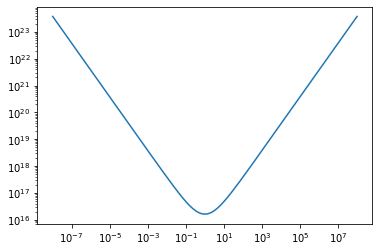

In [7]:
plt.loglog(R_AA_arr, sigma_data)

Now that we know $\Sigma$ is so incredibly large, lets take a look at the $\Pi_+$ and $\Pi_-$ values for cycles that go through all 8 states since they all have a $\Sigma_\text{K}$ of 1.

My $\textit{hypothesis}$ is the net cycle fluxes for these cycles will all be very close to zero $\textit{because}$ their $\Sigma_\text{K}$ values are 1. Cycle with flux diagrams likely have much higher net cycle flux numerators since many of the rates are very large, basically. 

In [8]:
pi_data, sigma_K_data = get_net_cycle_flux_data(k_AA_anti, k_AA_sym, all_cycles=all_cycles)
num_data = pi_data * sigma_K_data
J_K_data = num_data/sigma_data

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

The primary contributors to the operational flux near $R_\text{AA} = 1$ are cycles 14 and 25.

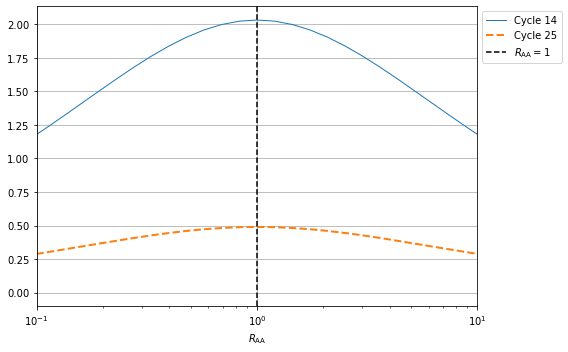

In [9]:
plot_cycle_data(x=R_AA_arr, y_arr=J_K_data, cycle_idx=[13, 24], logy=False)

Again looking at the $R_\text{AA} = 1$ case, the question to answer was 

$\textit{"Why is the net cycle flux for cycle 1 zero, or very close to it?"}$

Here we can see that cycles 1 and 20 (similar cycle structures) are both contributors, just very very small. The reason for this is the value of $\Sigma$ is just so much larger than their $\Pi_-$/$\Pi_+$ values. They also do not have any flux diagrams because they are 8-state cycles, so they get no assistance from $\Sigma_K$. 

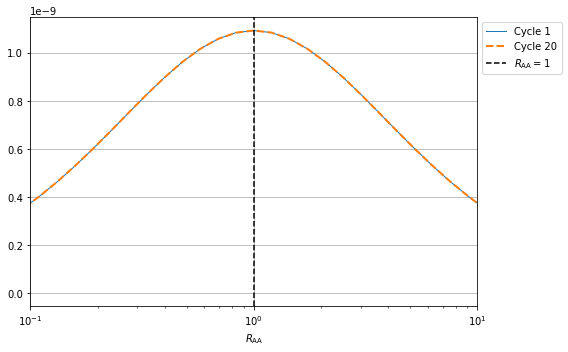

In [10]:
plot_cycle_data(x=R_AA_arr, y_arr=J_K_data, cycle_idx=[0, 19], logy=False)

With these cycles out of the way, we still have 4 remaining proton-transporting cycles to look at. 

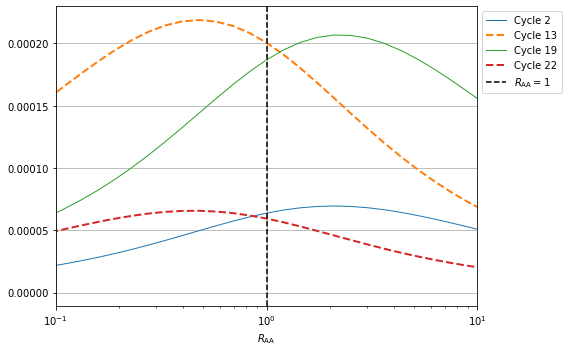

In [11]:
plot_cycle_data(x=R_AA_arr, y_arr=J_K_data, cycle_idx=[1, 12, 18, 21], logy=False)

These 4 cycles are actually much larger in magnitude compared to cycles 1 and 20, but again, not nearly large enough to be considered primary contributors to proton flux in the decoupled case.

While we are here, we might as well look at the remaining cycles and their contributions. To start, lets look at all cycles for which we know there is no thermodynamic driving force (based on visual inspection):

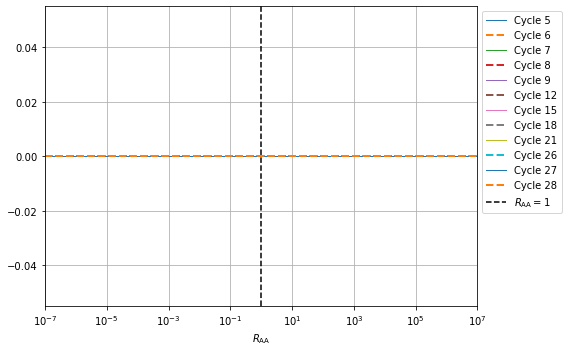

In [12]:
plot_cycle_data(x=R_AA_arr, y_arr=J_K_data, cycle_idx=[4, 5, 6, 7, 8, 11, 14, 17, 20, 25, 26, 27], logy=False, max_logx=7)

12 out of the 28 cycles do absolutely nothing across the entire range of $R_\text{AA}$. 4 of these do not have any binding/unbinding processes at all so cannot be driving by an ion gradient, and the remaining 8 cycles transport drug molecules but are zero due to the absence of a drug gradient. 

20 down, 8 to go...

The remaining 8 cycles are all coupled cycles, either antiport or symport, where their contributions are much larger at the extremes (i.e. $R_\text{AA} <<1$ for symport, $R_\text{AA} >>1$ for antiport) and relatively small at $R_\text{AA} =1$.  

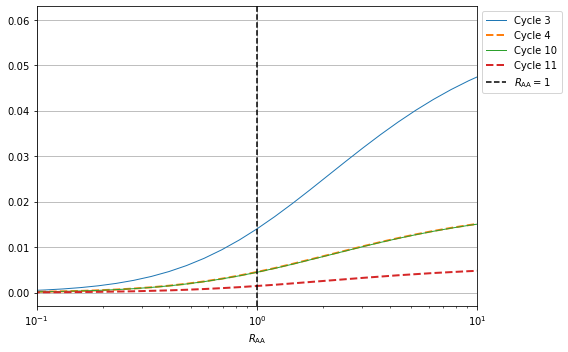

In [13]:
# antiport cycles
plot_cycle_data(x=R_AA_arr, y_arr=J_K_data, cycle_idx=[2, 3, 9, 10], logy=False)

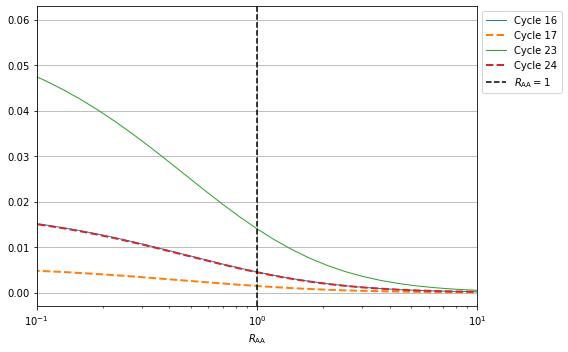

In [14]:
# symport cycles
plot_cycle_data(x=R_AA_arr, y_arr=J_K_data, cycle_idx=[15, 16, 22, 23], logy=False)

As we can see above, the coupled cycles are still contributors as well but do not contribute nearly as much as the original cycles 14 & 25. 

## Revisiting Cycles 14, 25

Now that we have an overview of all 28 cycles, lets look deeper into cycles 14 and 25 and try to understand why they are so much greater in magnitude than the other proton-driven cycles. Basically, let's try to answer the question

$\textit{"Why are cycles 14 and 25 so much greater in magnitude than the other proton-driven cycles?}$

The net cycle fluxes for cycles 14 and 25:

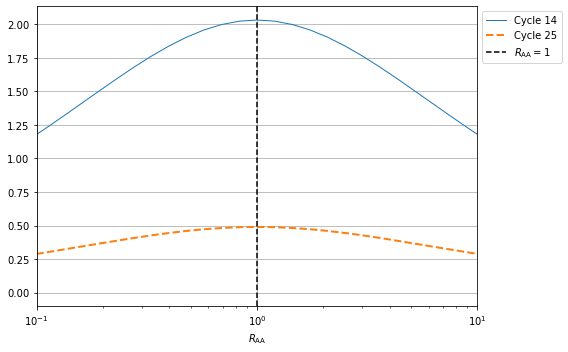

In [15]:
plot_cycle_data(x=R_AA_arr, y_arr=J_K_data, cycle_idx=[13, 24], logy=False)

To do this we can look at the net cycle fluxes broken down into their component pieces (i.e. $\Pi_{+/-}$, $\Sigma_K$). Let's start with the difference between forward and reverse rate products, $\Pi_{+} - \Pi_{-}$

### $\Pi_{+} - \Pi_{-}$ Analysis

#### $\Pi_{+} - \Pi_{-}$: Dominant Cycles

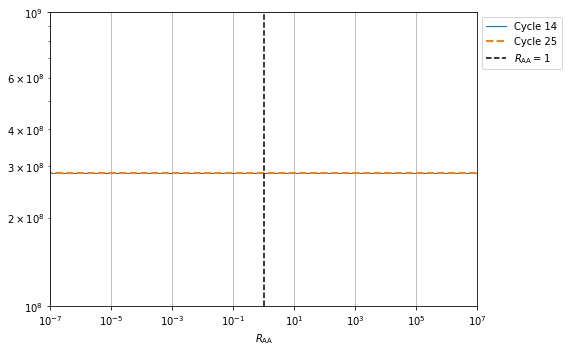

In [16]:
plot_cycle_data(x=R_AA_arr, y_arr=pi_data, cycle_idx=[13, 24], logy=True, max_logx=7)

We see that both cycles are constant across the entire range of $R_\text{AA}$ values. This makes sense because both of these cycles both a symport biasing process AND an antiport biasing process, so as one increases (logarithmically) the other decreases in equal proportion, leaving the rate products constant across the range. 

But is this property unique to cycles 14 and 25? Upon visual inspection, the remaining proton-only transporting cycles (cycles 1, 2, 13, 19, 20, and 22) share this property. The only cycles where protons are transported and this $\textit{isn't}$ the case are the symport and antiport cycles, where both symport rate paths and both antiport rate paths are chosen, respectively.   

#### $\Pi_{+} - \Pi_{-}$: Other Cycles

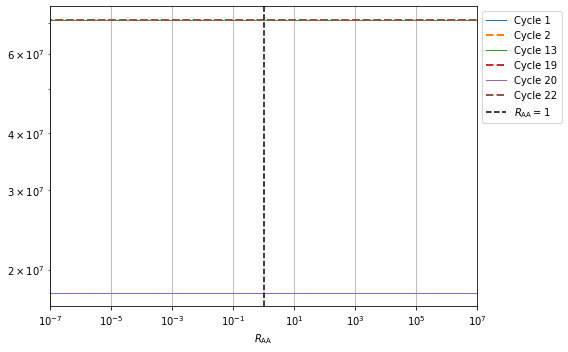

In [17]:
plot_cycle_data(x=R_AA_arr, y_arr=pi_data, cycle_idx=[0, 1, 12, 18, 19, 21], logy=True, max_logx=7)

### $\Sigma_K$ Analysis

Now let's take a look at $\Sigma_K$, the contributions from flux diagrams which are weighted by the rates along the possible pathways to the cycle of interest. 

#### $\Sigma_K$: Dominant Cycles 

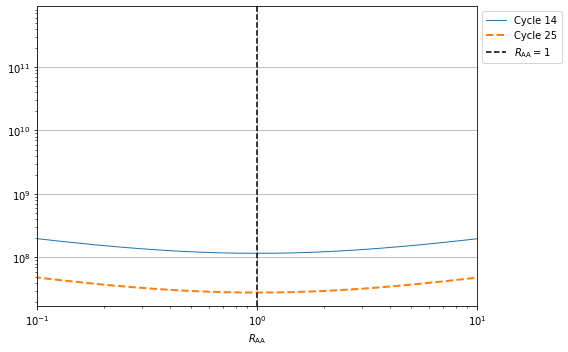

In [18]:
plot_cycle_data(x=R_AA_arr, y_arr=sigma_K_data, cycle_idx=[13, 24], logy=True, max_logx=1)

#### $\Sigma_K$: Other Cycles

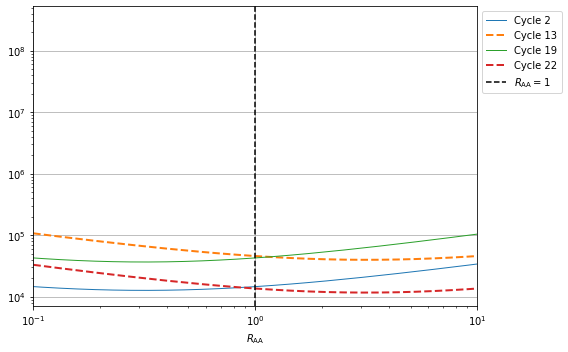

In [19]:
plot_cycle_data(x=R_AA_arr, y_arr=sigma_K_data, cycle_idx=[1, 12, 18, 21], logy=True, max_logx=1)

Cycles 1 and 20 are automatically excluded from the above figure because they are 8-node cycles, meaning their $\Sigma_K$ values is 1 by default.

But we can see here that on average there is a 3-4 order of magnitude drop relative to the dominant cycles, and thus 8-9 order of magnitude drop for cycles 1 and 20.

### $\Sigma$ Analysis

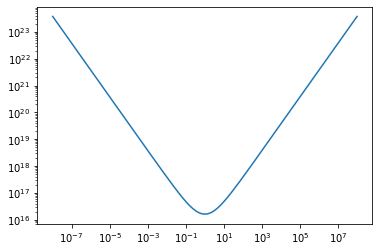

In [20]:
plt.loglog(R_AA_arr, sigma_data)